Setup

In [1]:
!pip uninstall -y numba numpy
!pip uninstall -y pygam
!pip install numpy==1.24.4 numba==0.57.1

Found existing installation: numba 0.57.1
Uninstalling numba-0.57.1:
  Successfully uninstalled numba-0.57.1
Found existing installation: numpy 1.24.4
Uninstalling numpy-1.24.4:
  Successfully uninstalled numpy-1.24.4
  Using cached numpy-1.24.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.6 kB)
  Using cached numba-0.57.1-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (2.7 kB)
Using cached numpy-1.24.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.3 MB)
Using cached numba-0.57.1-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (3.6 MB)


In [2]:
!pip install l0bnb linearmodels matplotlib seaborn scikit-learn xgboost lightgbm -q


In [3]:
#Import Needed Packages
import numpy as np
import pandas as pd
import networkx as nx
import statsmodels.api as sm
from matplotlib.pyplot import subplots
from statsmodels.api import OLS
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt


I. Import Replication Dataset and Impose Same Filters

In [4]:
main_data = pd.read_stata("OG Full Dataset.dta")
restricted = main_data[(main_data['date']<=29) & (main_data['date']>=10) &
                       (main_data['gustav']>=1) & (main_data['dist_lib']>=-1) & 
                        (main_data['dist_lib']<=10)]

restricted.head(10)

,year,month,date,cod_istat103,cod_prov103,cod_reg103,North,Center,South,gustav,...,p_voti2_liberali1924_miss,p_voti2_destra1924_miss,p_voti2_cattolici1924_miss,p_voti2_socialisti1924_miss,p_voti2_radicali1924_miss,p_voti2_repubblicani1924_miss,p_voti2_fascisti1924_miss,p_voti2_comunisti1924_miss,p_voti2_autonomisti1924_miss,p_voti2_altri1924_miss
5355,1944,6,18,1217,1,1,1,0,0,1,...,1,1,1,1,1,1,1,1,1,1
5356,1944,6,18,1219,1,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5357,1944,6,18,1229,1,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5358,1944,6,18,1312,1,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5359,1944,6,18,1085,1,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5360,1944,6,18,1009,1,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5361,1944,6,18,1272,1,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5362,1944,6,18,1290,1,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5363,1944,6,18,1111,1,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5364,1944,6,18,1098,1,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [5]:
#Rename dependant variables to something more intuitive
restricted = restricted.rename(columns = {"vict_rappr_aggr_AT_ep": "violence_episode_total", 
                                                          "vict_rappr_aggr_civ_AT_ep": "violence_episode_civilian_resistance", 
                                                          "vict_rappr_aggr_part_AT_ep": "violence_episode_partisan_resistance" })

     
#Rename controls to something more intuitive
restricted = restricted.rename(columns = {"MW_SNR": "BBC_SNR_Ratio",
                                         "rain": "avg_rainfall_millimeter",
                                         "cloud": "avg_cloud_coverage", 
                                         "temp": "avg_temperature"})

#Assign more intuitive names to the party variables
restricted.rename(columns=lambda x: x.replace('p_voti2_liberali', 'share_liberal') if 'p_voti2_liberali' in x else x, inplace=True)
restricted.rename(columns=lambda x: x.replace('p_voti2_socialisti', 'share_socialist') if 'p_voti2_socialisti' in x else x, inplace=True)
restricted.rename(columns=lambda x: x.replace('p_voti2_cattolici', 'share_catholic') if 'p_voti2_cattolici' in x else x, inplace=True)
restricted.rename(columns=lambda x: x.replace('p_voti2_comunisti', 'share_communist') if 'p_voti2_comunisti' in x else x, inplace=True)
restricted.rename(columns=lambda x: x.replace('p_voti2_fascisti', 'share_fascist') if 'p_voti2_fascisti' in x else x, inplace=True)
restricted.rename(columns=lambda x: x.replace('p_voti2_destra', 'share_conservative') if 'p_voti2_destra' in x else x, inplace=True)
restricted.rename(columns=lambda x: x.replace('p_voti2_autonomisti', 'share_independent') if 'p_voti2_autonomisti' in x else x, inplace=True)
restricted.rename(columns=lambda x: x.replace('p_voti2_altri', 'share_altri') if 'p_voti2_altri' in x else x, inplace=True)
restricted.rename(columns=lambda x: x.replace('p_voti2_radicali', 'share_radical') if 'p_voti2_radicali' in x else x, inplace=True)
restricted.rename(columns=lambda x: x.replace('p_voti2_repubblicani', 'share_republican') if 'p_voti2_repubblicani' in x else x, inplace=True)


#Restrict to the variables we need
restricted = restricted.loc[:, restricted.columns.str.contains('|'.join([ '1924', '1921', '1919', 'avg_cloud_coverage', 'avg_rainfall_millimeter', 
                                                                         'avg_temperature', 'BBC_SNR_Ratio', 'cod_istat103', 
                                                                         'violence_episode']))]
restricted = restricted.loc[:, ~restricted.columns.str.contains('_miss|_l01|_lgt1')]
print(restricted.columns.tolist())

['cod_istat103', 'violence_episode_total', 'violence_episode_civilian_resistance', 'violence_episode_partisan_resistance', 'BBC_SNR_Ratio', 'avg_rainfall_millimeter', 'avg_cloud_coverage', 'avg_temperature', 'share_liberal1919', 'share_conservative1919', 'share_catholic1919', 'share_socialist1919', 'share_radical1919', 'share_republican1919', 'share_fascist1919', 'share_communist1919', 'share_independent1919', 'share_altri1919', 'share_liberal1921', 'share_conservative1921', 'share_catholic1921', 'share_socialist1921', 'share_radical1921', 'share_republican1921', 'share_fascist1921', 'share_communist1921', 'share_independent1921', 'share_altri1921', 'share_liberal1924', 'share_conservative1924', 'share_catholic1924', 'share_socialist1924', 'share_radical1924', 'share_republican1924', 'share_fascist1924', 'share_communist1924', 'share_independent1924', 'share_altri1924']


II. Summary Statistics

In [6]:
#Aggregate the variables (to simple average)
collapse_columns = [col for col in restricted.columns if col != 'cod_istat103']
collapsed = restricted.groupby('cod_istat103')[collapse_columns].mean().reset_index()
#Drop NA-s 
collapsed = collapsed.replace([np.inf, -np.inf], np.nan).dropna()
collapsed.to_csv('collapsed_main.csv', index=False)

In [7]:
#Table 1:  Municipality-level 1919 Italian General Election Results
elec1919 = collapsed.loc[:, restricted.columns.str.contains('|'.join([ '1919']))]
summary19 = elec1919.describe()
summary19.to_csv('summary19.csv', index=False)


In [8]:
#Table 2:  Municipality-level 1921 Italian General Election Results
elec1921 = collapsed.loc[:, restricted.columns.str.contains('|'.join([ '1921']))]
summary21 = elec1921.describe()
summary21.to_csv('summary21.csv', index=False)

In [9]:
#Table 3:  Municipality-level 1924 Italian General Election Results
elec1924 = collapsed.loc[:, restricted.columns.str.contains('|'.join([ '1924']))]
summary24 = elec1924.describe()
summary24.to_csv('summary24.csv', index=False)

In [10]:
#Table 4: Average Monthly Number of Nazi Reprisals against Resistance
dep_sum = collapsed.loc[:, restricted.columns.str.contains('|'.join([ 'violence_episode']))]
dep_sum = dep_sum.describe()
dep_sum.to_csv('dep_sum.csv', index=False)

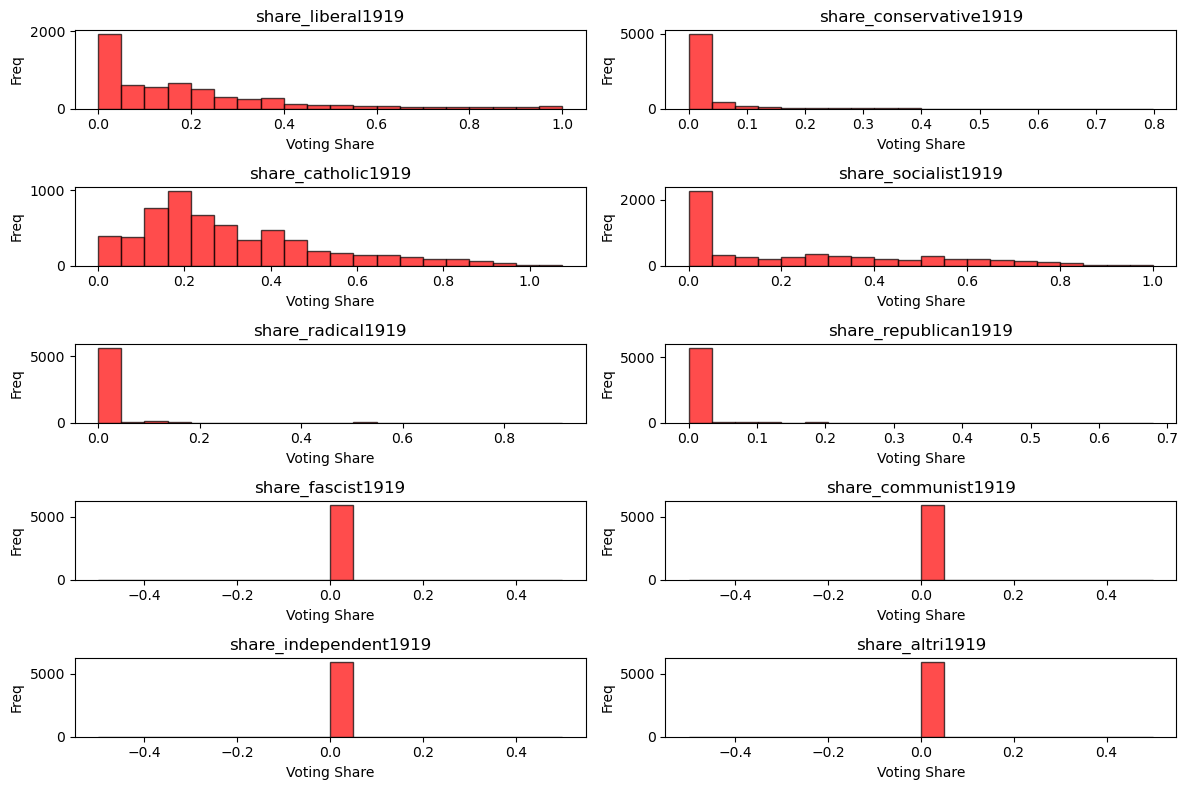

In [11]:
#Figure A.1: Municipality-level Voting Shares in 1919 
f, yx = plt.subplots(5, 2, figsize=(12, 8))
yx = yx.flatten()

for party, column in enumerate(elec1919.columns):
    yx_mod = yx[party]  
    yx_mod.hist(elec1919[column], bins=20, alpha=0.7, color='red', edgecolor='black')
    yx_mod.set_title(f'{column}')
    yx_mod.set_xlabel('Voting Share')
    yx_mod.set_ylabel('Freq')

for i in range(len(elec1919.columns), len(yx)):
    f.delaxes(yx_mod[i])

plt.tight_layout()
plt.show()

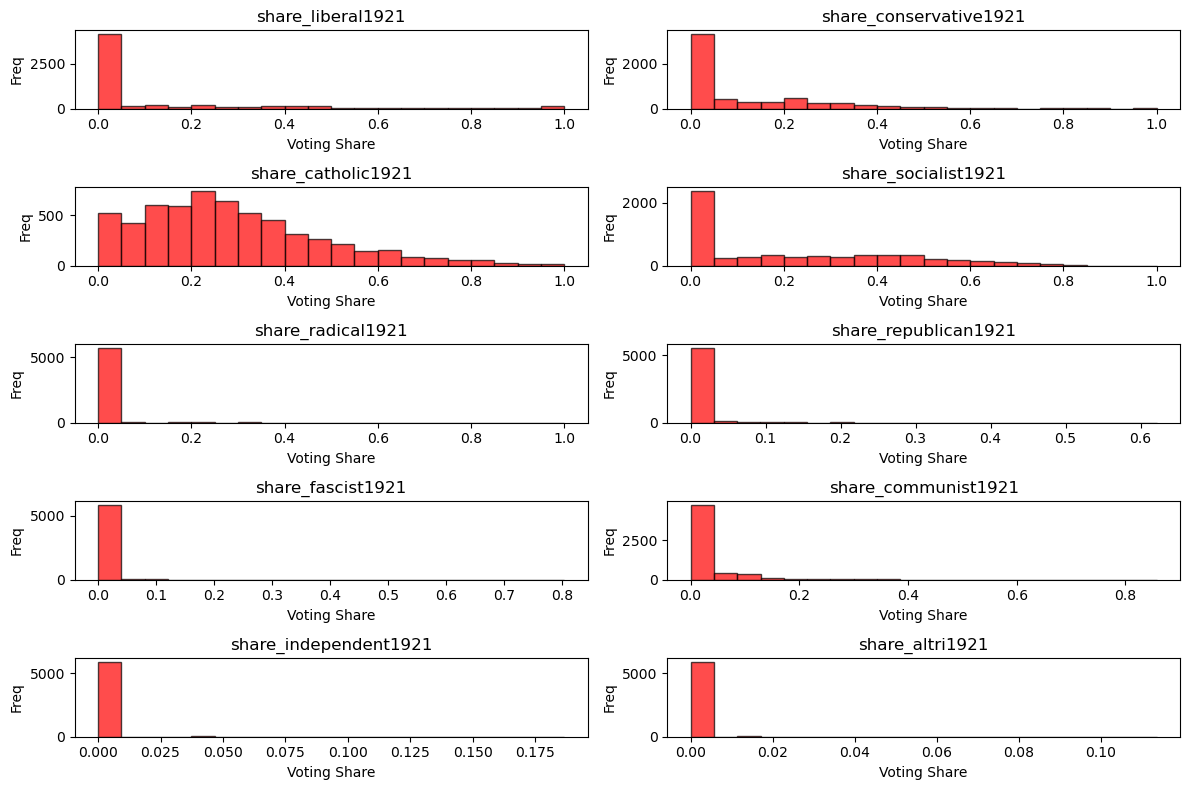

In [12]:
#Figure A.2: Municipality-level Voting Shares in 1921
f, yx = plt.subplots(5, 2, figsize=(12, 8))
yx = yx.flatten()

for party, column in enumerate(elec1921.columns):
    yx_mod = yx[party]  
    yx_mod.hist(elec1921[column], bins=20, alpha=0.7, color='red', edgecolor='black')
    yx_mod.set_title(f'{column}')
    yx_mod.set_xlabel('Voting Share')
    yx_mod.set_ylabel('Freq')

for i in range(len(elec1921.columns), len(yx)):
    f.delaxes(yx_mod[i])

plt.tight_layout()
plt.show()

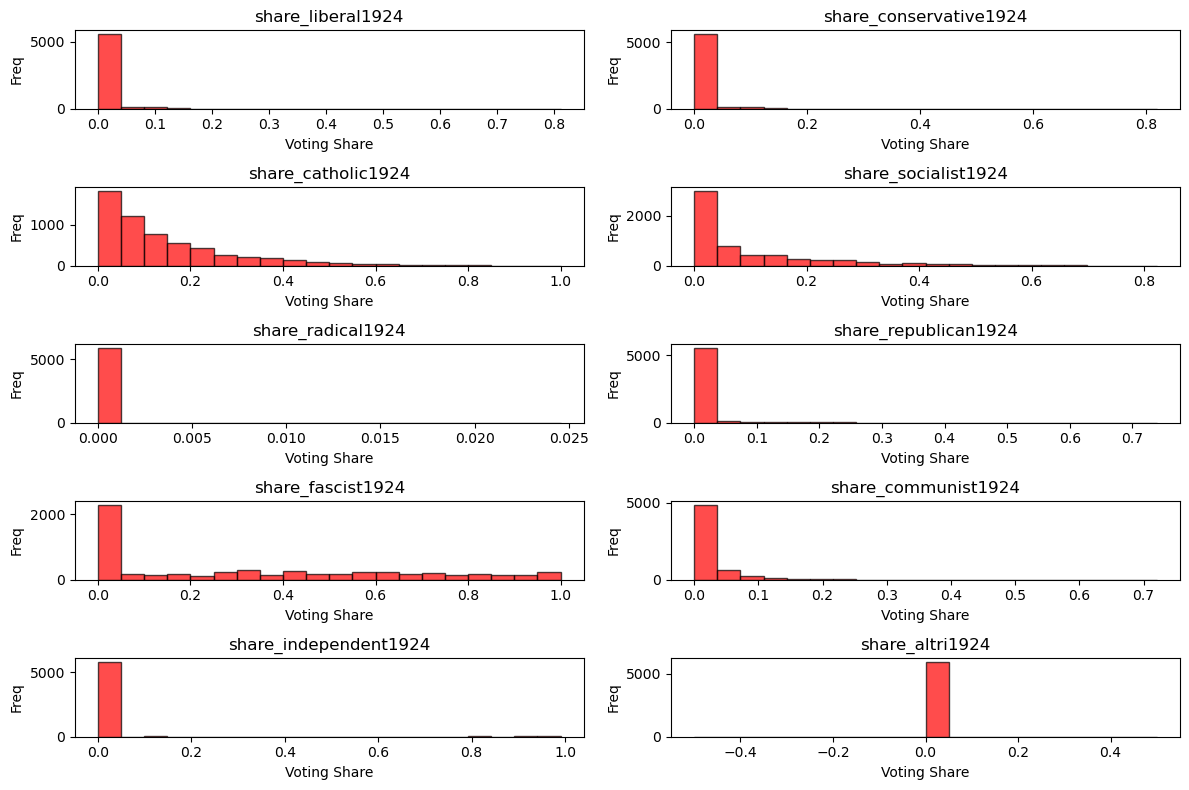

In [13]:
#Figure A.3: Municipality-level Voting Shares in 1924
f, yx = plt.subplots(5, 2, figsize=(12, 8))
yx = yx.flatten()

for party, column in enumerate(elec1924.columns):
    yx_mod = yx[party]  
    yx_mod.hist(elec1924[column], bins=20, alpha=0.7, color='red', edgecolor='black')
    yx_mod.set_title(f'{column}')
    yx_mod.set_xlabel('Voting Share')
    yx_mod.set_ylabel('Freq')

for i in range(len(elec1924.columns), len(yx)):
    f.delaxes(yx_mod[i])

plt.tight_layout()
plt.show()

III. DAG Graph

In [14]:
#Prepare set-up for GML Graph
my_gml = """graph [
directed 1

node [
    id 3
    label "Party Vote %"
    ]

node [
    id 1
    label "Mean(Reprisals)"
    ]
  
node [
    id 2
    label "Control: weather"
]


node [
    id 0
    label "Control: radio"
]

edge [
    source 0
    target 1
    ]
    
edge [
    source 2
    target 1
    ]
    
    edge [
    source 3
    target 1
    ]
    
    
    edge [
    source 0
    target 3
    ]
    
       edge [
    source 2
    target 3
    ]
    
    
]
    
    """

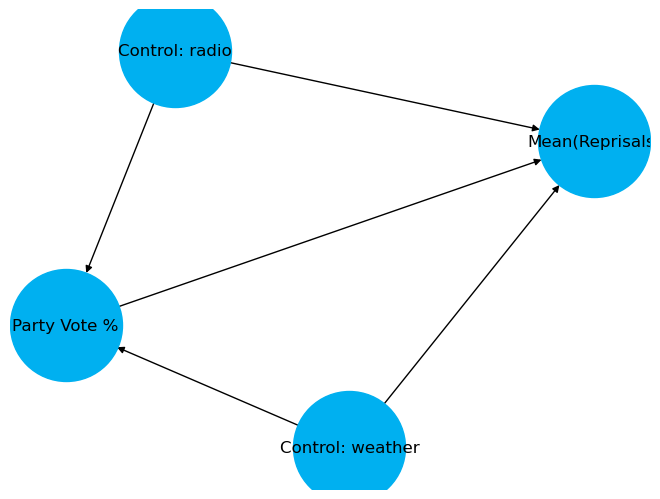

In [15]:
#Figure 1: Directed Acyclic Graph of the Main Model
graph = nx.parse_gml(my_gml)

nx.draw(
    G=graph, 
    with_labels=True,
    node_size=6500,
    node_color=[
    '#00B0F0',
    '#FF0000'
][0],
    font_color='black'
)

IV. Regression Model

In [16]:
#Table 5:  OLS Regression using 1919 Election Results
x = collapsed.loc[:, restricted.columns.str.contains('|'.join([ '1919',  'avg_cloud_coverage', 'avg_rainfall_millimeter', 'avg_temperature', 'BBC_SNR_Ratio']))]
y = collapsed['violence_episode_total']
x = sm.add_constant(x)
model = sm.OLS(y, x).fit()
print(model.summary())
latex_output = model.summary().as_latex ()
print(latex_output)

                              OLS Regression Results                              
Dep. Variable:     violence_episode_total   R-squared:                       0.091
Model:                                OLS   Adj. R-squared:                  0.089
Method:                     Least Squares   F-statistic:                     58.82
Date:                    Sun, 20 Oct 2024   Prob (F-statistic):          3.76e-114
Time:                            00:09:22   Log-Likelihood:                -3049.3
No. Observations:                    5921   AIC:                             6121.
Df Residuals:                        5910   BIC:                             6194.
Df Model:                              10                                         
Covariance Type:                nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

/opt/conda/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1965: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])


In [17]:
#Table 7:  OLS Regression using 1921 Election Results
x = collapsed.loc[:, restricted.columns.str.contains('|'.join([ '1921',  'avg_cloud_coverage', 'avg_rainfall_millimeter', 'avg_temperature', 'BBC_SNR_Ratio']))]
y = collapsed['violence_episode_total']
x = sm.add_constant(x)
model = sm.OLS(y, x).fit()
print(model.summary())
latex_output = model.summary().as_latex ()
print(latex_output)

                              OLS Regression Results                              
Dep. Variable:     violence_episode_total   R-squared:                       0.090
Model:                                OLS   Adj. R-squared:                  0.088
Method:                     Least Squares   F-statistic:                     41.77
Date:                    Sun, 20 Oct 2024   Prob (F-statistic):          4.18e-110
Time:                            00:09:24   Log-Likelihood:                -3050.7
No. Observations:                    5921   AIC:                             6131.
Df Residuals:                        5906   BIC:                             6232.
Df Model:                              14                                         
Covariance Type:                nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

In [18]:
#Table 9:  OLS Regression using 1924 Election Results
x = collapsed.loc[:, restricted.columns.str.contains('|'.join([ '1924',  'avg_cloud_coverage', 'avg_rainfall_millimeter', 'avg_temperature', 'BBC_SNR_Ratio']))]
y = collapsed['violence_episode_total']
x = sm.add_constant(x)
model = sm.OLS(y, x).fit()
print(model.summary())
latex_output = model.summary().as_latex ()
print(latex_output)

                              OLS Regression Results                              
Dep. Variable:     violence_episode_total   R-squared:                       0.088
Model:                                OLS   Adj. R-squared:                  0.086
Method:                     Least Squares   F-statistic:                     44.08
Date:                    Sun, 20 Oct 2024   Prob (F-statistic):          1.24e-108
Time:                            00:09:25   Log-Likelihood:                -3056.1
No. Observations:                    5921   AIC:                             6140.
Df Residuals:                        5907   BIC:                             6234.
Df Model:                              13                                         
Covariance Type:                nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

/opt/conda/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1965: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])


V. Random Forest Model

In [19]:
#Table 6: Importance Matrix for Random Forest (1919 Election Results)
x = collapsed.loc[:, restricted.columns.str.contains('|'.join([ '1919',  'avg_cloud_coverage', 'avg_rainfall_millimeter', 'avg_temperature', 'BBC_SNR_Ratio']))]
y = collapsed['violence_episode_total']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=55)
rf_model = RandomForestRegressor(
    n_estimators=1000,  
    max_depth=5,       
    random_state=55   
)
rf_model.fit(x_train, y_train)

y_pred = rf_model.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
print(f'MSE (1919): {mse}')

r2 = r2_score(y_test, y_pred)
print(f'R-squared (1919): {r2}')

importance_matrix = rf_model.feature_importances_
importance_for_graph = pd.DataFrame({
    'Variable': x.columns,
    'Importance': importance_matrix
}).sort_values(by='Importance', ascending=False)

print(importance_for_graph)

MSE (1919): 0.11711704295148484
R-squared (1919): 0.15197046226864697
                   Variable  Importance
3           avg_temperature    0.282995
1   avg_rainfall_millimeter    0.221715
6        share_catholic1919    0.198952
0             BBC_SNR_Ratio    0.136680
2        avg_cloud_coverage    0.057404
4         share_liberal1919    0.041225
8         share_radical1919    0.040672
7       share_socialist1919    0.009871
9      share_republican1919    0.005486
5    share_conservative1919    0.005000
10        share_fascist1919    0.000000
11      share_communist1919    0.000000
12    share_independent1919    0.000000
13          share_altri1919    0.000000


In [20]:
#Table 8: Importance Matrix for Random Forest (1921 Election Results)

x = collapsed.loc[:, restricted.columns.str.contains('|'.join([ '1921',  'avg_cloud_coverage', 'avg_rainfall_millimeter', 'avg_temperature', 'BBC_SNR_Ratio']))]
y = collapsed['violence_episode_total']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=55)
rf_model = RandomForestRegressor(
    n_estimators=1000,  
    max_depth=5,       
    random_state=55   
)
rf_model.fit(x_train, y_train)

y_pred = rf_model.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
print(f'MSE (1921): {mse}')

r2 = r2_score(y_test, y_pred)
print(f'R-squared (1921): {r2}')

importance_matrix = rf_model.feature_importances_
importance_for_graph = pd.DataFrame({
    'Variable': x.columns,
    'Importance': importance_matrix
}).sort_values(by='Importance', ascending=False)

print(importance_for_graph)


MSE (1921): 0.12403026506153503
R-squared (1921): 0.1019127046402496
                   Variable  Importance
3           avg_temperature    0.285430
1   avg_rainfall_millimeter    0.178793
4         share_liberal1921    0.157536
6        share_catholic1921    0.118436
0             BBC_SNR_Ratio    0.102656
2        avg_cloud_coverage    0.052902
7       share_socialist1921    0.048016
8         share_radical1921    0.044412
9      share_republican1921    0.006017
11      share_communist1921    0.004783
5    share_conservative1921    0.000816
13          share_altri1921    0.000201
10        share_fascist1921    0.000003
12    share_independent1921    0.000000


In [21]:
#Table 10: Importance Matrix for Random Forest (1924 Election Results)

x = collapsed.loc[:, restricted.columns.str.contains('|'.join([ '1924',  'avg_cloud_coverage', 'avg_rainfall_millimeter', 'avg_temperature', 'BBC_SNR_Ratio']))]
y = collapsed['violence_episode_total']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=55)
rf_model = RandomForestRegressor(
    n_estimators=1000,  
    max_depth=5,       
    random_state=55   
)
rf_model.fit(x_train, y_train)

y_pred = rf_model.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
print(f'MSE (1924): {mse}')

r2 = r2_score(y_test, y_pred)
print(f'R-squared (1924): {r2}')

importance_matrix = rf_model.feature_importances_
importance_for_graph = pd.DataFrame({
    'Variable': x.columns,
    'Importance': importance_matrix
}).sort_values(by='Importance', ascending=False)

print(importance_for_graph)

MSE (1924): 0.13168503275560475
R-squared (1924): 0.0464855102247288
                   Variable  Importance
3           avg_temperature    0.346444
1   avg_rainfall_millimeter    0.304301
0             BBC_SNR_Ratio    0.181412
2        avg_cloud_coverage    0.090037
6        share_catholic1924    0.070412
7       share_socialist1924    0.003112
11      share_communist1924    0.001462
4         share_liberal1924    0.001211
9      share_republican1924    0.000802
10        share_fascist1924    0.000469
8         share_radical1924    0.000325
5    share_conservative1924    0.000007
12    share_independent1924    0.000006
13          share_altri1924    0.000000


VI. Robustness Checks

In [28]:
#Table 11: OLS Model Cross-Validation Results - 1919
x = collapsed.loc[:, restricted.columns.str.contains('|'.join([ '1919',  'avg_cloud_coverage', 'avg_rainfall_millimeter', 'avg_temperature', 'BBC_SNR_Ratio']))]
y = collapsed['violence_episode_total']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=55)
ols_model = skl.LinearRegression()
cv = skm.cross_val_score(ols_model, x_train, y_train, cv=5, scoring='neg_mean_squared_error')
mean_cv_mse = -cv.mean()
print(f'Mean CV MSE (1919): {mean_cv_mse}')
ols_model.fit(x_train, y_train)
y_pred = ols_model.predict(x_test)
test_mse = mean_squared_error(y_test, y_pred)
print(f'Test MSE (1919): {test_mse}')
     
test_r2 = r2_score(y_test, y_pred)
print(f'R-squared (1919): {test_r2}')

Mean CV MSE (1919): 0.18010991220107161
Test MSE (1919): 0.12070633755174119
R-squared (1919): 0.12598083886347


In [27]:
#Table 11: OLS Model Cross-Validation Results - 1921
x = collapsed.loc[:, restricted.columns.str.contains('|'.join([ '1921',  'avg_cloud_coverage', 'avg_rainfall_millimeter', 'avg_temperature', 'BBC_SNR_Ratio']))]
y = collapsed['violence_episode_total']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=55)
ols_model = skl.LinearRegression()
cv = skm.cross_val_score(ols_model, x_train, y_train, cv=5, scoring='neg_mean_squared_error')
mean_cv_mse = -cv.mean()
print(f'Mean CV MSE (1921): {mean_cv_mse}')

ols_model.fit(x_train, y_train)
y_pred = ols_model.predict(x_test)
test_mse = mean_squared_error(y_test, y_pred)
print(f'Test MSE (1921): {test_mse}')
      
test_r2 = r2_score(y_test, y_pred)
print(f'R-squared (1921): {test_r2}')
  

Mean CV MSE (1921): 0.18194179236414026
Test MSE (1921): 0.12223865909515182
R-squared (1921): 0.11488549443394391


In [30]:
#Table 11: OLS Model Cross-Validation Results - 1924
x = collapsed.loc[:, restricted.columns.str.contains('|'.join([ '1924',  'avg_cloud_coverage', 'avg_rainfall_millimeter', 'avg_temperature', 'BBC_SNR_Ratio']))]
y = collapsed['violence_episode_total']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=55)
ols_model = skl.LinearRegression()
cv = skm.cross_val_score(ols_model, x_train, y_train, cv=5, scoring='neg_mean_squared_error')
mean_cv_mse = -cv.mean()
print(f'Mean CV MSE (1924): {mean_cv_mse}')

ols_model.fit(x_train, y_train)
y_pred = ols_model.predict(x_test)
test_mse = mean_squared_error(y_test, y_pred)
print(f'Test MSE (1924): {test_mse}')


test_r2 = r2_score(y_test, y_pred)
print(f'R-squared (1924): {test_r2}')

Mean CV MSE (1924): 0.17979471589816867
Test MSE (1924): 0.12211237429760845
R-squared (1924): 0.11579990651082306


In [31]:
#Table 12: Importance Matrix for Gradient Boosting - 1919
x = collapsed.loc[:, restricted.columns.str.contains('|'.join([ '1919',  'avg_cloud_coverage', 'avg_rainfall_millimeter', 'avg_temperature', 'BBC_SNR_Ratio']))]
y = collapsed['violence_episode_total']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=55)
boosting_model = GradientBoostingRegressor(
    n_estimators=1000,
    learning_rate = 0.1,
    max_depth=5,       
    random_state=55   
)

boosting_model.fit(x_train, y_train)
y_pred = boosting_model.predict(x_test)
print(f'MSE (1919): {mse}')

mse = mean_squared_error(y_test, y_pred)
r_squared = r2_score(y_test, y_pred)
print(f'R-squared (1919): {r2}')

boosting_imp = boosting_model.feature_importances_
importance_matrix = pd.DataFrame({'Variable': x.columns, 'Importance': boosting_imp})
importance_matrix = importance_matrix.sort_values(by='Importance', ascending=False)
print(importance_matrix)

MSE (1919): 0.15369940979902078
R-squared (1919): 0.0464855102247288
                   Variable  Importance
3           avg_temperature    0.224650
6        share_catholic1919    0.222691
1   avg_rainfall_millimeter    0.213826
0             BBC_SNR_Ratio    0.140858
2        avg_cloud_coverage    0.063401
4         share_liberal1919    0.052024
8         share_radical1919    0.042717
7       share_socialist1919    0.025440
5    share_conservative1919    0.007253
9      share_republican1919    0.007141
10        share_fascist1919    0.000000
11      share_communist1919    0.000000
12    share_independent1919    0.000000
13          share_altri1919    0.000000


In [32]:
#Table 12: Importance Matrix for Gradient Boosting - 1921
x = collapsed.loc[:, restricted.columns.str.contains('|'.join([ '1921',  'avg_cloud_coverage', 'avg_rainfall_millimeter', 'avg_temperature', 'BBC_SNR_Ratio']))]
y = collapsed['violence_episode_total']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=55)
boosting_model = GradientBoostingRegressor(
    n_estimators=1000,
    learning_rate = 0.1,
    max_depth=5,       
    random_state=55   
)

boosting_model.fit(x_train, y_train)
y_pred = boosting_model.predict(x_test)
print(f'MSE (1921): {mse}')

mse = mean_squared_error(y_test, y_pred)
r_squared = r2_score(y_test, y_pred)
print(f'R-squared (1921): {r2}')

boosting_imp = boosting_model.feature_importances_
importance_matrix = pd.DataFrame({'Variable': x.columns, 'Importance': boosting_imp})
importance_matrix = importance_matrix.sort_values(by='Importance', ascending=False)
print(importance_matrix)

MSE (1921): 0.12896106268187052
R-squared (1921): 0.0464855102247288
                   Variable  Importance
3           avg_temperature    0.229151
4         share_liberal1921    0.217230
1   avg_rainfall_millimeter    0.129769
0             BBC_SNR_Ratio    0.124332
6        share_catholic1921    0.107610
2        avg_cloud_coverage    0.067367
7       share_socialist1921    0.065076
8         share_radical1921    0.031098
9      share_republican1921    0.011566
5    share_conservative1921    0.008957
11      share_communist1921    0.005407
13          share_altri1921    0.001784
10        share_fascist1921    0.000516
12    share_independent1921    0.000137


In [33]:
#Table 12: Importance Matrix for Gradient Boosting - 1924
x = collapsed.loc[:, restricted.columns.str.contains('|'.join([ '1924',  'avg_cloud_coverage', 'avg_rainfall_millimeter', 'avg_temperature', 'BBC_SNR_Ratio']))]
y = collapsed['violence_episode_total']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=55)
boosting_model = GradientBoostingRegressor(
    n_estimators=1000,
    learning_rate = 0.1,
    max_depth=5,       
    random_state=55   
)

boosting_model.fit(x_train, y_train)
y_pred = boosting_model.predict(x_test)
print(f'MSE (1924): {mse}')

mse = mean_squared_error(y_test, y_pred)
r_squared = r2_score(y_test, y_pred)
print(f'R-squared (1924): {r2}')

boosting_imp = boosting_model.feature_importances_
importance_matrix = pd.DataFrame({'Variable': x.columns, 'Importance': boosting_imp})
importance_matrix = importance_matrix.sort_values(by='Importance', ascending=False)
print(importance_matrix)

MSE: 0.15369940979902078
R-squared: 0.0464855102247288
                   Variable  Importance
3           avg_temperature    0.291375
1   avg_rainfall_millimeter    0.259345
0             BBC_SNR_Ratio    0.220387
2        avg_cloud_coverage    0.107572
6        share_catholic1924    0.066739
9      share_republican1924    0.012480
11      share_communist1924    0.012436
4         share_liberal1924    0.010079
7       share_socialist1924    0.009366
10        share_fascist1924    0.007586
12    share_independent1924    0.001162
8         share_radical1924    0.000943
5    share_conservative1924    0.000528
13          share_altri1924    0.000000
